In [47]:
import imageio
import torch
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline


In [48]:
# Load gif: 
gif = imageio.mimread('data/1kWp.gif')

for i in range(len(gif)):
    print(gif[i].shape)

(700, 500)
(700, 500, 4)
(700, 500, 4)
(700, 500, 4)
(700, 500, 4)
(700, 500, 4)
(700, 500, 4)


Something weird seems to be going on with the frames, so we check with a subplot, where each row corresponds to the element in the `img` list

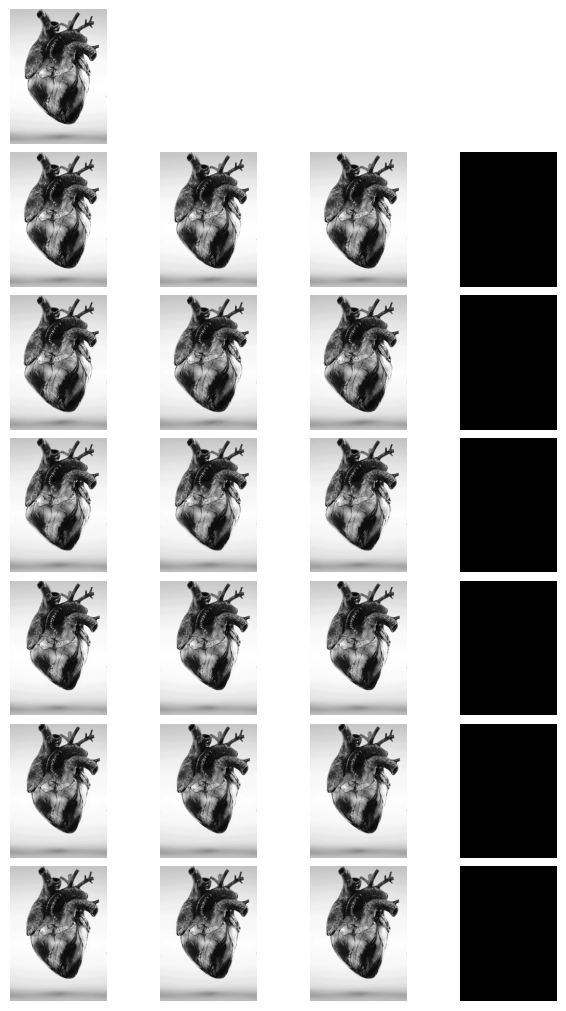

In [49]:
fig,ax=plt.subplots(7,4,figsize=(6,10),constrained_layout=True)
ax[0,0].imshow(gif[0],cmap='gray')
ax[0,0].axis('off')

ax[0,1].set_visible(False)
ax[0,2].set_visible(False)
ax[0,3].set_visible(False)

for i in range(1,len(gif)):
    for j in range(4):
        ax[i,j].imshow(gif[i][:,:,j],cmap='gray')
        ax[i,j].axis('off')
plt.show()


First three images within each element of the list seems to be identical, let's verify..

In [50]:
for i in range(1,len(gif)):
    print(f'List element {i}')
    print(np.all(gif[i][:,:,0]==gif[i][:,:,1]))
    print(np.all(gif[i][:,:,0]==gif[i][:,:,2]))
    print(np.all(gif[i][:,:,1]==gif[i][:,:,2]),'\n')


List element 1
True
True
True 

List element 2
True
True
True 

List element 3
True
True
True 

List element 4
True
True
True 

List element 5
True
True
True 

List element 6
True
True
True 



That is indeed true. We then convert to a 3D array

In [51]:
im=[]
im.append(gif[0])
for i in range(1,len(gif)):
    im.append(gif[i][:,:,0].astype(float))

# Convert list to numpy array
im=np.asarray(im)

print(im.shape)

(7, 700, 500)


For some descriptive statistics, let's look at the mean and median per frame and overall as well as a per-frame and overall histogram:

Per-frame mean and median value:

Mean: [167.501 165.938 165.29  170.584 173.547 172.881 171.086]
Median: [197. 197. 197. 202. 205. 205. 202.]
overall mean and median value:

Mean 169.547
Median 202.0


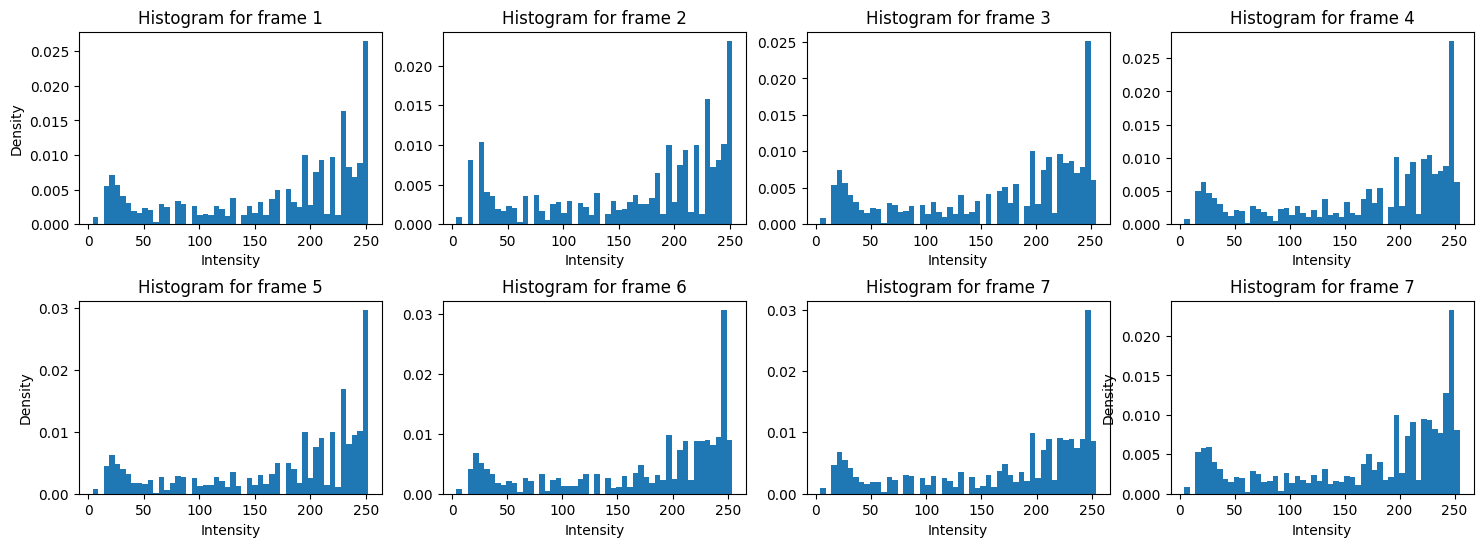

In [52]:
print('Per-frame mean and median value:\n')
print('Mean:',im.mean(axis=(1,2)).round(3))
print('Median:',np.median(im,axis=(1,2)))

print('overall mean and median value:\n')
print('Mean',im.mean().round(3))
print('Median',np.median(im))


fig,ax=plt.subplots(2,4,figsize=(18,6))
ax=ax.ravel()
for i in range(len(im)):
    _ = ax[i].hist(im[i].ravel(),bins=50,density=True)
    ax[i].set_title(f'Histogram for frame {i+1}')
    ax[i].set_xlabel('Intensity')
    if (i==0) or (i==4):
        ax[i].set_ylabel('Density')

_ = ax[-1].hist(im.ravel(),bins=50,density=True)
ax[-1].set_title(f'Histogram for frame {i+1}')
ax[-1].set_xlabel('Intensity')
ax[-1].set_ylabel('Density')

plt.subplots_adjust(hspace=0.4)





We then create the corresponding binary image. For now we simply threshold at the middle intensity

In [53]:
imBin = (im < int(np.max(im)/2)).astype(float)

We then visualize both the grayscale gif and the binary gif for 5 cycles

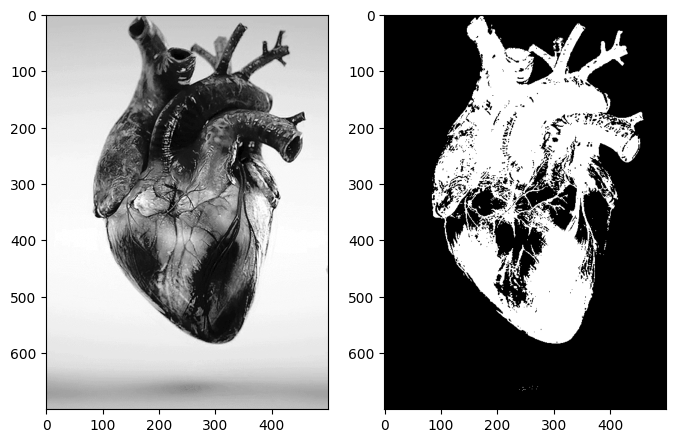

In [54]:
for t in range(5):
    for i in range(im.shape[0]):
        clear_output(wait=True)
        fig,ax=plt.subplots(1,2,figsize=(8,6))
        ax[0].imshow(im[i],cmap='gray')
        ax[1].imshow(imBin[i],cmap='gray')
        plt.show()

Next, we will downsample the image as it currently contains $700 \cdot 500 = 3.5\cdot 10^5$ pixels per frame, which (at least for initial experiments) is way too much

In [55]:
scaleFactor=10
new_dim=(int(im.shape[2]/scaleFactor),int(im.shape[1]/scaleFactor)) # For some reason it should be opposite

imScaled=[]
imBinScaled=[]
for i in range(im.shape[0]):
    tmp = cv2.resize(im[i],new_dim)
    imScaled.append(tmp)

    tmp = cv2.resize(imBin[i],new_dim)
    imBinScaled.append(tmp)

imScaled = np.array(imScaled)
imBinScaled = np.array(imBinScaled)




We then visualize again

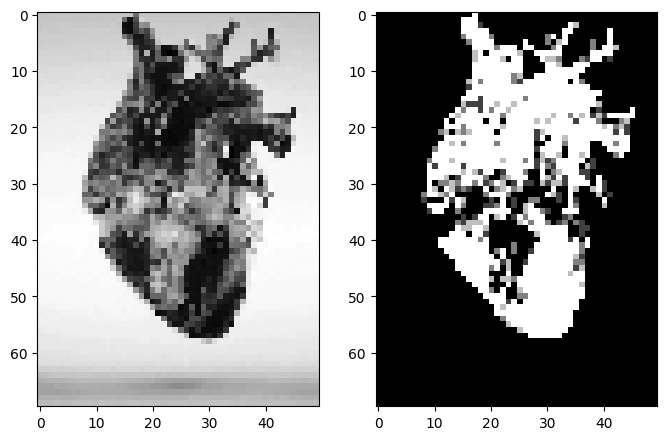

In [56]:
for t in range(5):
    for i in range(im.shape[0]):
        clear_output(wait=True)
        fig,ax=plt.subplots(1,2,figsize=(8,6))
        ax[0].imshow(imScaled[i],cmap='gray')
        ax[1].imshow(imBinScaled[i],cmap='gray')
        plt.show()

With a scale factor of 10 we now have 3500 pixels per frame

Finally, we unravel image frames such that we have them in the format used for temporal models, i.e. we are reshaping from (7,H,W) to (7,H*W)

In [57]:
vecLen=imScaled.shape[1]*imScaled.shape[2]
imScaledVec = imScaled.reshape(7,vecLen)
imBinScaledVec = imBinScaled.reshape(7,vecLen)

In [58]:
print(imScaledVec.shape)

(7, 3500)
